# Classification of Cancer associated Mutations from Literature using Machine Learning

Use the "Run" button to execute the code.

In [1]:
pip install jovian --upgrade --quiet

Note: you may need to restart the kernel to use updated packages.


distutils: C:\Users\anubr\anaconda3\Include\UNKNOWN
sysconfig: C:\Users\anubr\anaconda3\Include
user = False
home = None
root = None
prefix = None
distutils: C:\Users\anubr\anaconda3\Include\UNKNOWN
sysconfig: C:\Users\anubr\anaconda3\Include
user = False
home = None
root = None
prefix = None


In [51]:
# Execute this to save new versions of the notebook
jovian.commit(project="jovian-ml-project-030122",filename="jovian-ml-project-030122")

<IPython.core.display.Javascript object>

[jovian] Creating a new project "anubratadas/jovian-ml-project-030122"
[jovian] Committed successfully! https://jovian.ai/anubratadas/jovian-ml-project-030122


'https://jovian.ai/anubratadas/jovian-ml-project-030122'

### <font color='green'>Import the essential libraries</font>

In [3]:
import jovian
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import xml.etree.ElementTree as ET
import time
import re
from tqdm import tqdm
%matplotlib inline

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import warnings
warnings.simplefilter(action='ignore')

In [5]:
tqdm.pandas(desc="progress bar")

 ### <font style="font-size:18px;font-family:arial;color:green;text-indent:100px;line-height: 0.8;word-spacing: 10px"> A cancerous tissue can have thousands of genetic mutations (Variations), which are discovered using genome sequencing. But the challenge is distinguishing the mutations that contribute to tumor growth (drivers) from the neutral mutations (passengers). Currently this interpretation of genetic mutations is being done manually. This is a very time-consuming task where a clinical pathologist has to manually review and classify every single genetic mutation based on evidence from text-based clinical literature. For this competition MSKCC is making available an expert-annotated knowledge base where world-class researchers and oncologists have manually annotated thousands of mutations. MSKCC intends the Data scientist to develop a Machine Learning algorithm that, using this knowledge base as a baseline, automatically classifies genetic variations.</font>

<a id='top'>**Beginning of Notebook**</a>

[model train text data](#train_data)

### <font color='green'>Exploratory Data Analysis</font>

###  references
  - https://github.com/ghostintheshellarise/2021HackForRare
  - https://widdowquinn.github.io/2018-03-06-ibioic/02-sequence_databases/09-KEGG_programming.html
  - https://bioservices.readthedocs.io/en/master/kegg_tutorial.html
  - https://bioservices.readthedocs.io/en/master/index.html

#### train data

In [6]:
train_text_df = pd.read_csv('training_text.zip', sep="\|\|", encoding="utf-8",engine="python", skiprows=1, names=["ID", "Text"],compression='zip')

In [7]:
train_variant_df = pd.read_csv('training_variants.zip',compression='zip')

In [8]:
train_text_df.shape, train_variant_df.shape

((3321, 2), (3321, 4))

In [9]:
train_text_df.columns, train_variant_df.columns

(Index(['ID', 'Text'], dtype='object'),
 Index(['ID', 'Gene', 'Variation', 'Class'], dtype='object'))

In [10]:
# merging the text and variation data
train_df = pd.merge(train_variant_df,train_text_df,on='ID')

In [11]:
train_df.shape

(3321, 5)

In [12]:
# taking a sample of the dataset
train_df = train_df.sample(frac=0.4,random_state=222)

We have taken a sample of the training data

In [13]:
train_df.head()

,ID,Gene,Variation,Class,Text
1708,1708,POLE,S459del,1,Tumors with somatic mutations in the proofread...
2201,2201,PTEN,D92A,4,The PTEN (phosphatase and tensin homolog) phos...
84,84,RIT1,A77T,2,Abstract RASopathies are autosomal dominant d...
1985,1985,CTNNB1,I35S,7,To understand the nature and roles of mutated ...
2985,2985,KIT,W557R,7,Purpose: Somatic mutations that result in the ...


### <font style="font-size:18px;font-family:arial;color:green;text-indent:100px;line-height: 0.8;word-spacing: 10px"><i>Gene</i> is a stretch of DNA encoding a specific function. Variation is <i>Mutation</i>,  which changes the function. The first alphabet is the orginal amino acid, the number is the physical position in the gene where the change has occured and the last alphabet is the changed amino acid. The Text contains the information for the Gene, the Variation and the reason for the Class </font>

#### top 10 mutated genes

In [14]:
# top 10 mutated genes
train_df.groupby('Gene')['Variation'].aggregate("count").sort_values(ascending=False).head(n=10)

Gene
BRCA1     101
TP53       69
EGFR       56
BRCA2      56
PTEN       52
KIT        45
BRAF       40
ALK        28
PDGFRA     27
ERBB2      27
Name: Variation, dtype: int64

In [15]:
mutated_genes=train_df['Gene'].to_list()

### Importing Biopython library for pathway analysis

In [16]:
#!pip install biopython

In [17]:
#!pip install bioservices

In [18]:
from Bio import SeqIO
from Bio.KEGG import REST
from bioservices.kegg import KEGG
from collections import deque
import networkx as nx
from IPython.display import Image
import time
import io
import os
from itertools import chain

In [19]:
print(REST.kegg_info('pathway').read())

pathway          KEGG Pathway Database
path             Release 101.0+/01-03, Jan 22
                 Kanehisa Laboratories
                 864,450 entries

linked db        module
                 ko
                 genome
                 <org>
                 compound
                 glycan
                 reaction
                 rclass
                 enzyme
                 network
                 disease
                 drug
                 pubmed



In [20]:
kegg_obj=KEGG()

In [21]:
print(kegg_obj.get("hsa:ALK"))

ENTRY       238               CDS       T01001
SYMBOL      ALK, ALK1, CD246, NBLST3
NAME        (RefSeq) ALK receptor tyrosine kinase
ORTHOLOGY   K05119  anaplastic lymphoma kinase [EC:2.7.10.1]
ORGANISM    hsa  Homo sapiens (human)
PATHWAY     hsa05200  Pathways in cancer
            hsa05223  Non-small cell lung cancer
            hsa05235  PD-L1 expression and PD-1 checkpoint pathway in cancer
NETWORK     nt06210  ERK signaling
            nt06214  PI3K signaling
            nt06219  JAK-STAT signaling
            nt06220  Calcium signaling
            nt06266  Non-small cell lung cancer
  ELEMENT   N00007  EML4-ALK fusion kinase to RAS-ERK signaling pathway
            N00025  EML4-ALK fusion kinase to PLCG-ERK signaling pathway
            N00047  EML4-ALK fusion kinase to PI3K signaling pathway
            N00105  EML4-ALK fusion kinase to Jak-STAT signaling pathway
            N10003  First-generation tyrosine kinase inhibitor to ALK fusion
            N10004  Second/third-gener

In [22]:
print(kegg_obj.find("hsa","ALK")[:300])

hsa:256710	GLIPR1L1, ALKN2972, PRO7434; GLIPR1 like 1
hsa:392636	AGMO, TMEM195; alkylglycerol monooxygenase
hsa:2585	GALK2, GK2; galactokinase 2
hsa:55331	ACER3, APHC, PHCA, PLDECO; alkaline ceramidase 3
hsa:83795	KCNK16, K2p16.1, TALK-1, TALK1; potassium two pore domain channel subfamily K member 1


In [23]:
print(REST.kegg_get('hsa:ALK','aaseq').read()[:300])

>hsa:238 K05119 anaplastic lymphoma kinase [EC:2.7.10.1] | (RefSeq) ALK, ALK1, CD246, NBLST3; ALK receptor tyrosine kinase (A)
MGAIGLLWLLPLLLSTAAVGSGMGTGQRAGSPAAGPPLQPREPLSYSRLQRKSLAVDFVV
PSLFRVYARDLLLPPSSSELKAGRPEARGSLALDCAPLLRLLGPAPGVSWTAGSPAPAEA
RTLSRVLKGGSVRKLRRAKQLVLELGEEAILEGCVGPPGEAAVGLLQFNLS


In [24]:
print(kegg_obj.get_pathway_by_gene("238","hsa"))

WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (238               CDS       T01001) into github.com/bioservices. Thanks T.C.


{'hsa05200': 'Pathways in cancer', 'hsa05223': 'Non-small cell lung cancer', 'hsa05235': 'PD-L1 expression and PD-1 checkpoint pathway in cancer'}


In [25]:
human_gene_list=kegg_obj.list('hsa')

In [26]:
human_gene_list=human_gene_list.split('\n')

In [27]:
import re

In [28]:
human_gene_list[0]

'hsa:100616498\tMIR378E, mir-378e; microRNA 378e'

In [29]:
re.sub('[\t;]',',',human_gene_list[0])

'hsa:100616498,MIR378E, mir-378e, microRNA 378e'

In [30]:
re.search('^\w+:\w+','hsa:100616498\tMIR378E, mir-378e; microRNA 378e')

<re.Match object; span=(0, 13), match='hsa:100616498'>

In [31]:
re.search('\t\w+','hsa:100616498\tMIR378E, mir-378e; microRNA 378e').group()[1:]

'MIR378E'

In [32]:
def get_kegg_indices(human_gene_list):
    gene_kegg_id_dict={}
    for item in human_gene_list:
        try:
            kegg_id=re.search('^\w+:\w+',item).group()
        except:
            kegg_id='no_entry'
        try:
            gene=re.search('\t\w+',item).group()[1:]
        except:
            gene='no_gene'            
        gene_kegg_id_dict[gene]=kegg_id
    return gene_kegg_id_dict    

In [33]:
def map_mutation_kegg(mutated_genes,human_gene_list):
    print("mutated genes",len(mutated_genes))
    print("kegg genes",len(human_gene_list))
    mut_gene_kegg=[]
    kegg_gene_dict=get_kegg_indices(human_gene_list)
    for mut_gene in mutated_genes:
        if mut_gene in kegg_gene_dict:
            gene_tup=(mut_gene,kegg_gene_dict[mut_gene])
            mut_gene_kegg.append(gene_tup)
    return mut_gene_kegg        

In [35]:
mutated_kegg=map_mutation_kegg(mutated_genes,human_gene_list)

mutated genes 1328
kegg genes 22232


In [37]:
print(kegg_obj.get_pathway_by_gene("BRCA2","hsa"))

WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (675               CDS       T01001) into github.com/bioservices. Thanks T.C.


{'hsa03440': 'Homologous recombination', 'hsa03460': 'Fanconi anemia pathway', 'hsa05200': 'Pathways in cancer', 'hsa05212': 'Pancreatic cancer', 'hsa05224': 'Breast cancer'}


In [48]:
test=mutated_genes[:6]

In [57]:
def df_gene_pathway():    
    df_gene_pathway=pd.DataFrame(columns=["gene","pathway"])
    for gene in tqdm(mutated_genes):    
        try:
            pathway_origin=kegg_obj.get_pathway_by_gene(gene,"hsa")
            pathway_list=list(pathway_origin.keys())
            for pathway in pathway_list:
                df_gene_pathway=df_gene_pathway.append({"pathway":pathway,"gene":gene},ignore_index=True)
        except:
            print("no data for ",gene)
    return df_gene_pathway       

In [58]:
gene_pathway=df_gene_pathway()
gene_pathway.shape

  0%|          | 0/1328 [00:00<?, ?it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (5426              CDS       T01001) into github.com/bioservices. Thanks T.C.
  0%|          | 1/1328 [00:01<23:53,  1.08s/it]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (5728              CDS       T01001) into github.com/bioservices. Thanks T.C.
  0%|          | 2/1328 [00:01<14:04,  1.57it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (6016              CDS       T01001) into github.com/bioservices. Thanks T.C.
  0%|          | 3/1328 [00:01<09:40,  2.28it/s]

no data for  RIT1


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (1499              CDS       T01001) into github.com/bioservices. Thanks T.C.
  0%|          | 4/1328 [00:02<09:38,  2.29it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (3815              CDS       T01001) into github.com/bioservices. Thanks T.C.
  0%|          | 5/1328 [00:02<08:09,  2.71it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (567               CDS       T01001) into github.com/bioservices. Thanks T.C.
  0%|          | 6/1328 [00:02<07:48,  2.82it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
 

  2%|▏         | 30/1328 [00:12<08:00,  2.70it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (3815              CDS       T01001) into github.com/bioservices. Thanks T.C.
  2%|▏         | 31/1328 [00:12<07:12,  3.00it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (1387              CDS       T01001) into github.com/bioservices. Thanks T.C.
  2%|▏         | 32/1328 [00:13<08:30,  2.54it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (2064              CDS       T01001) into github.com/bioservices. Thanks T.C.
  2%|▏         | 33/1328 [00:13<07:45,  2.78it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsin

  4%|▍         | 57/1328 [00:23<09:27,  2.24it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (6608              CDS       T01001) into github.com/bioservices. Thanks T.C.
  4%|▍         | 58/1328 [00:23<08:00,  2.64it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (3815              CDS       T01001) into github.com/bioservices. Thanks T.C.
  4%|▍         | 59/1328 [00:23<08:04,  2.62it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (1956              CDS       T01001) into github.com/bioservices. Thanks T.C.
  5%|▍         | 60/1328 [00:24<09:06,  2.32it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsin

no data for  ROS1


  6%|▌         | 75/1328 [00:29<07:28,  2.80it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (672               CDS       T01001) into github.com/bioservices. Thanks T.C.
  6%|▌         | 76/1328 [00:29<07:14,  2.88it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (3815              CDS       T01001) into github.com/bioservices. Thanks T.C.
  6%|▌         | 77/1328 [00:30<06:43,  3.10it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (7113              CDS       T01001) into github.com/bioservices. Thanks T.C.
  6%|▌         | 78/1328 [00:30<06:36,  3.16it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsin

  8%|▊         | 102/1328 [00:40<07:02,  2.90it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (5728              CDS       T01001) into github.com/bioservices. Thanks T.C.
  8%|▊         | 103/1328 [00:40<07:17,  2.80it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (1956              CDS       T01001) into github.com/bioservices. Thanks T.C.
  8%|▊         | 104/1328 [00:41<08:27,  2.41it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (54790             CDS       T01001) into github.com/bioservices. Thanks T.C.
  8%|▊         | 105/1328 [00:41<07:03,  2.89it/s]

no data for  TET2


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (861               CDS       T01001) into github.com/bioservices. Thanks T.C.
  8%|▊         | 106/1328 [00:41<07:22,  2.76it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (54790             CDS       T01001) into github.com/bioservices. Thanks T.C.
  8%|▊         | 107/1328 [00:41<06:26,  3.16it/s]

no data for  TET2


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (7428              CDS       T01001) into github.com/bioservices. Thanks T.C.
  8%|▊         | 108/1328 [00:42<06:43,  3.02it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (672               CDS       T01001) into github.com/bioservices. Thanks T.C.
  8%|▊         | 109/1328 [00:42<06:11,  3.28it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (673               CDS       T01001) into github.com/bioservices. Thanks T.C.
  8%|▊         | 110/1328 [00:43<08:08,  2.49it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the K

no data for  ELF3


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (3845              CDS       T01001) into github.com/bioservices. Thanks T.C.
  9%|▊         | 114/1328 [00:45<10:01,  2.02it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (7157              CDS       T01001) into github.com/bioservices. Thanks T.C.
  9%|▊         | 115/1328 [00:45<09:33,  2.12it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (5156              CDS       T01001) into github.com/bioservices. Thanks T.C.
  9%|▊         | 116/1328 [00:45<08:28,  2.38it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the K

no data for  PPP6C


  9%|▉         | 122/1328 [00:48<07:56,  2.53it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (675               CDS       T01001) into github.com/bioservices. Thanks T.C.
  9%|▉         | 123/1328 [00:48<07:50,  2.56it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (4352              CDS       T01001) into github.com/bioservices. Thanks T.C.
  9%|▉         | 124/1328 [00:48<06:48,  2.95it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (2263              CDS       T01001) into github.com/bioservices. Thanks T.C.
  9%|▉         | 125/1328 [00:49<07:11,  2.79it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    pa

 11%|█         | 149/1328 [00:57<06:32,  3.01it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (2072              CDS       T01001) into github.com/bioservices. Thanks T.C.
 11%|█▏        | 150/1328 [00:57<05:49,  3.37it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (4088              CDS       T01001) into github.com/bioservices. Thanks T.C.
 11%|█▏        | 151/1328 [00:58<06:31,  3.01it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (7428              CDS       T01001) into github.com/bioservices. Thanks T.C.
 11%|█▏        | 152/1328 [00:58<05:50,  3.36it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    pa

no data for  DDR2


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (2099              CDS       T01001) into github.com/bioservices. Thanks T.C.
 12%|█▏        | 155/1328 [00:59<06:07,  3.19it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (5518              CDS       T01001) into github.com/bioservices. Thanks T.C.
 12%|█▏        | 156/1328 [00:59<05:50,  3.34it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (5537              CDS       T01001) into github.com/bioservices. Thanks T.C.
 12%|█▏        | 157/1328 [00:59<05:43,  3.41it/s]

no data for  PPP6C


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (5879              CDS       T01001) into github.com/bioservices. Thanks T.C.
 12%|█▏        | 158/1328 [01:00<06:48,  2.86it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (57492             CDS       T01001) into github.com/bioservices. Thanks T.C.
 12%|█▏        | 159/1328 [01:00<06:06,  3.19it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (6098              CDS       T01001) into github.com/bioservices. Thanks T.C.
 12%|█▏        | 160/1328 [01:00<06:06,  3.18it/s]

no data for  ROS1


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (7048              CDS       T01001) into github.com/bioservices. Thanks T.C.
 12%|█▏        | 161/1328 [01:01<06:09,  3.15it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (3845              CDS       T01001) into github.com/bioservices. Thanks T.C.
 12%|█▏        | 162/1328 [01:01<08:31,  2.28it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (2475              CDS       T01001) into github.com/bioservices. Thanks T.C.
 12%|█▏        | 163/1328 [01:02<09:59,  1.94it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the K

 14%|█▍        | 187/1328 [01:12<07:17,  2.61it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (672               CDS       T01001) into github.com/bioservices. Thanks T.C.
 14%|█▍        | 188/1328 [01:13<07:43,  2.46it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (472               CDS       T01001) into github.com/bioservices. Thanks T.C.
 14%|█▍        | 189/1328 [01:13<07:52,  2.41it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (2475              CDS       T01001) into github.com/bioservices. Thanks T.C.
 14%|█▍        | 190/1328 [01:14<08:42,  2.18it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    pa

no data for  BAP1


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (6098              CDS       T01001) into github.com/bioservices. Thanks T.C.
 15%|█▌        | 201/1328 [01:18<07:29,  2.51it/s]

no data for  ROS1


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (2064              CDS       T01001) into github.com/bioservices. Thanks T.C.
 15%|█▌        | 202/1328 [01:18<07:03,  2.66it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (675               CDS       T01001) into github.com/bioservices. Thanks T.C.
 15%|█▌        | 203/1328 [01:19<07:14,  2.59it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (6416              CDS       T01001) into github.com/bioservices. Thanks T.C.
 15%|█▌        | 204/1328 [01:19<06:46,  2.77it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the K

no data for  KDM5C


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (4089              CDS       T01001) into github.com/bioservices. Thanks T.C.
 17%|█▋        | 228/1328 [01:29<06:14,  2.94it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (5290              CDS       T01001) into github.com/bioservices. Thanks T.C.
 17%|█▋        | 229/1328 [01:29<08:48,  2.08it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (672               CDS       T01001) into github.com/bioservices. Thanks T.C.
 17%|█▋        | 230/1328 [01:30<07:31,  2.43it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the K

 19%|█▉        | 254/1328 [01:39<06:15,  2.86it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (25                CDS       T01001) into github.com/bioservices. Thanks T.C.
 19%|█▉        | 255/1328 [01:40<06:32,  2.73it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (672               CDS       T01001) into github.com/bioservices. Thanks T.C.
 19%|█▉        | 256/1328 [01:40<05:53,  3.03it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (2175              CDS       T01001) into github.com/bioservices. Thanks T.C.
 19%|█▉        | 257/1328 [01:40<05:46,  3.09it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    pa

no data for  FAM58A


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (4893              CDS       T01001) into github.com/bioservices. Thanks T.C.
 20%|██        | 266/1328 [01:44<08:08,  2.18it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (23476             CDS       T01001) into github.com/bioservices. Thanks T.C.
 20%|██        | 267/1328 [01:44<06:45,  2.61it/s]

no data for  BRD4


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (5156              CDS       T01001) into github.com/bioservices. Thanks T.C.
 20%|██        | 268/1328 [01:44<07:04,  2.50it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (5781              CDS       T01001) into github.com/bioservices. Thanks T.C.
 20%|██        | 269/1328 [01:45<06:31,  2.71it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (3815              CDS       T01001) into github.com/bioservices. Thanks T.C.
 20%|██        | 270/1328 [01:45<06:06,  2.89it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the K

no data for  ROS1


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (672               CDS       T01001) into github.com/bioservices. Thanks T.C.
 21%|██▏       | 283/1328 [01:50<06:27,  2.70it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (675               CDS       T01001) into github.com/bioservices. Thanks T.C.
 21%|██▏       | 284/1328 [01:50<06:24,  2.72it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (1956              CDS       T01001) into github.com/bioservices. Thanks T.C.
 21%|██▏       | 285/1328 [01:51<07:50,  2.22it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the K

no data for  TET2


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (7080              CDS       T01001) into github.com/bioservices. Thanks T.C.
 22%|██▏       | 297/1328 [01:55<04:58,  3.45it/s]

no data for  NKX2-1


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (2475              CDS       T01001) into github.com/bioservices. Thanks T.C.
 22%|██▏       | 298/1328 [01:55<06:53,  2.49it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (2033              CDS       T01001) into github.com/bioservices. Thanks T.C.
 23%|██▎       | 299/1328 [01:56<07:09,  2.40it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (673               CDS       T01001) into github.com/bioservices. Thanks T.C.
 23%|██▎       | 300/1328 [01:56<07:43,  2.22it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the K

no data for  TET1


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (1493              CDS       T01001) into github.com/bioservices. Thanks T.C.
 24%|██▍       | 319/1328 [02:03<05:22,  3.13it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (1956              CDS       T01001) into github.com/bioservices. Thanks T.C.
 24%|██▍       | 320/1328 [02:03<06:24,  2.62it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (1029              CDS       T01001) into github.com/bioservices. Thanks T.C.
 24%|██▍       | 321/1328 [02:04<05:50,  2.87it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the K

 26%|██▌       | 345/1328 [02:14<04:55,  3.33it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (55294             CDS       T01001) into github.com/bioservices. Thanks T.C.
 26%|██▌       | 346/1328 [02:14<05:03,  3.23it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (3169              CDS       T01001) into github.com/bioservices. Thanks T.C.
 26%|██▌       | 347/1328 [02:14<04:29,  3.64it/s]

no data for  FOXA1


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (2064              CDS       T01001) into github.com/bioservices. Thanks T.C.
 26%|██▌       | 348/1328 [02:15<05:12,  3.14it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (4087              CDS       T01001) into github.com/bioservices. Thanks T.C.
 26%|██▋       | 349/1328 [02:15<05:02,  3.24it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (5295              CDS       T01001) into github.com/bioservices. Thanks T.C.
 26%|██▋       | 350/1328 [02:16<07:40,  2.12it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the K

no data for  NPM1


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (5728              CDS       T01001) into github.com/bioservices. Thanks T.C.
 27%|██▋       | 362/1328 [02:20<06:07,  2.63it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (1956              CDS       T01001) into github.com/bioservices. Thanks T.C.
 27%|██▋       | 363/1328 [02:21<06:52,  2.34it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (3815              CDS       T01001) into github.com/bioservices. Thanks T.C.
 27%|██▋       | 364/1328 [02:21<05:59,  2.68it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the K

no data for  BCOR


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (2261              CDS       T01001) into github.com/bioservices. Thanks T.C.
 29%|██▉       | 388/1328 [02:31<05:20,  2.93it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (2065              CDS       T01001) into github.com/bioservices. Thanks T.C.
 29%|██▉       | 389/1328 [02:31<04:52,  3.21it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (1029              CDS       T01001) into github.com/bioservices. Thanks T.C.
 29%|██▉       | 390/1328 [02:31<05:10,  3.02it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the K

 31%|███       | 414/1328 [02:40<07:03,  2.16it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (672               CDS       T01001) into github.com/bioservices. Thanks T.C.
 31%|███▏      | 415/1328 [02:41<06:01,  2.53it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (2322              CDS       T01001) into github.com/bioservices. Thanks T.C.
 31%|███▏      | 416/1328 [02:41<05:45,  2.64it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (5781              CDS       T01001) into github.com/bioservices. Thanks T.C.
 31%|███▏      | 417/1328 [02:41<05:15,  2.89it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    pa

no data for  PTPRT


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (3815              CDS       T01001) into github.com/bioservices. Thanks T.C.
 32%|███▏      | 421/1328 [02:43<05:46,  2.62it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (5156              CDS       T01001) into github.com/bioservices. Thanks T.C.
 32%|███▏      | 422/1328 [02:43<05:18,  2.84it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (10664             CDS       T01001) into github.com/bioservices. Thanks T.C.
 32%|███▏      | 423/1328 [02:43<04:45,  3.17it/s]

no data for  CTCF


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (51755             CDS       T01001) into github.com/bioservices. Thanks T.C.
 32%|███▏      | 424/1328 [02:44<04:42,  3.20it/s]

no data for  CDK12


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (3265              CDS       T01001) into github.com/bioservices. Thanks T.C.
 32%|███▏      | 425/1328 [02:44<06:51,  2.20it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (2065              CDS       T01001) into github.com/bioservices. Thanks T.C.
 32%|███▏      | 426/1328 [02:45<05:45,  2.61it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (80312             CDS       T01001) into github.com/bioservices. Thanks T.C.
 32%|███▏      | 427/1328 [02:45<05:27,  2.75it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the K

no data for  TET1


 32%|███▏      | 428/1328 [02:45<04:48,  3.12it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (5979              CDS       T01001) into github.com/bioservices. Thanks T.C.
 32%|███▏      | 429/1328 [02:46<04:51,  3.08it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (5426              CDS       T01001) into github.com/bioservices. Thanks T.C.
 32%|███▏      | 430/1328 [02:46<04:29,  3.34it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (6774              CDS       T01001) into github.com/bioservices. Thanks T.C.
 32%|███▏      | 431/1328 [02:46<05:06,  2.93it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    pa

no data for  AGO2


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (672               CDS       T01001) into github.com/bioservices. Thanks T.C.
 33%|███▎      | 436/1328 [02:48<04:40,  3.18it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (675               CDS       T01001) into github.com/bioservices. Thanks T.C.
 33%|███▎      | 437/1328 [02:48<04:57,  2.99it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (672               CDS       T01001) into github.com/bioservices. Thanks T.C.
 33%|███▎      | 438/1328 [02:48<04:29,  3.30it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the K

 35%|███▍      | 462/1328 [02:59<06:10,  2.34it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (5925              CDS       T01001) into github.com/bioservices. Thanks T.C.
 35%|███▍      | 463/1328 [02:59<05:49,  2.47it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (5604              CDS       T01001) into github.com/bioservices. Thanks T.C.
 35%|███▍      | 464/1328 [03:00<07:41,  1.87it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (207               CDS       T01001) into github.com/bioservices. Thanks T.C.
 35%|███▌      | 465/1328 [03:01<09:01,  1.59it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    pa

 37%|███▋      | 489/1328 [03:10<04:46,  2.93it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (3815              CDS       T01001) into github.com/bioservices. Thanks T.C.
 37%|███▋      | 490/1328 [03:10<04:30,  3.09it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (3815              CDS       T01001) into github.com/bioservices. Thanks T.C.
 37%|███▋      | 491/1328 [03:11<04:41,  2.97it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (2778              CDS       T01001) into github.com/bioservices. Thanks T.C.
 37%|███▋      | 492/1328 [03:11<05:10,  2.69it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    pa

no data for  FAT1


 38%|███▊      | 511/1328 [03:19<05:01,  2.71it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (2322              CDS       T01001) into github.com/bioservices. Thanks T.C.
 39%|███▊      | 512/1328 [03:19<04:26,  3.06it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (7428              CDS       T01001) into github.com/bioservices. Thanks T.C.
 39%|███▊      | 513/1328 [03:19<04:28,  3.04it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (1030              CDS       T01001) into github.com/bioservices. Thanks T.C.
 39%|███▊      | 514/1328 [03:20<04:11,  3.24it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    pa

no data for  ROS1


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (3815              CDS       T01001) into github.com/bioservices. Thanks T.C.
 39%|███▉      | 517/1328 [03:21<04:24,  3.07it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (9817              CDS       T01001) into github.com/bioservices. Thanks T.C.
 39%|███▉      | 518/1328 [03:21<03:59,  3.38it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (3845              CDS       T01001) into github.com/bioservices. Thanks T.C.
 39%|███▉      | 519/1328 [03:22<06:08,  2.20it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the K

no data for  DDR2


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (10413             CDS       T01001) into github.com/bioservices. Thanks T.C.
 40%|███▉      | 528/1328 [03:25<04:13,  3.16it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (672               CDS       T01001) into github.com/bioservices. Thanks T.C.
 40%|███▉      | 529/1328 [03:25<03:52,  3.43it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (2066              CDS       T01001) into github.com/bioservices. Thanks T.C.
 40%|███▉      | 530/1328 [03:26<04:06,  3.23it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the K

 42%|████▏     | 554/1328 [03:35<04:03,  3.18it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (5604              CDS       T01001) into github.com/bioservices. Thanks T.C.
 42%|████▏     | 555/1328 [03:35<05:42,  2.26it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (3845              CDS       T01001) into github.com/bioservices. Thanks T.C.
 42%|████▏     | 556/1328 [03:36<06:42,  1.92it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (2261              CDS       T01001) into github.com/bioservices. Thanks T.C.
 42%|████▏     | 557/1328 [03:36<05:36,  2.29it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    pa

 44%|████▍     | 581/1328 [03:46<05:26,  2.29it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (672               CDS       T01001) into github.com/bioservices. Thanks T.C.
 44%|████▍     | 582/1328 [03:47<04:36,  2.70it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (673               CDS       T01001) into github.com/bioservices. Thanks T.C.
 44%|████▍     | 583/1328 [03:47<05:45,  2.16it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (5156              CDS       T01001) into github.com/bioservices. Thanks T.C.
 44%|████▍     | 584/1328 [03:48<05:06,  2.43it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    pa

 46%|████▌     | 608/1328 [03:58<04:27,  2.69it/s]

no data for  ASXL1


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (2066              CDS       T01001) into github.com/bioservices. Thanks T.C.
 46%|████▌     | 609/1328 [03:58<04:21,  2.75it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (10000             CDS       T01001) into github.com/bioservices. Thanks T.C.
 46%|████▌     | 610/1328 [03:59<05:57,  2.01it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (7428              CDS       T01001) into github.com/bioservices. Thanks T.C.
 46%|████▌     | 611/1328 [03:59<04:58,  2.41it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the K

 48%|████▊     | 635/1328 [04:09<05:23,  2.14it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (2261              CDS       T01001) into github.com/bioservices. Thanks T.C.
 48%|████▊     | 636/1328 [04:09<05:05,  2.26it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (5290              CDS       T01001) into github.com/bioservices. Thanks T.C.
 48%|████▊     | 637/1328 [04:10<06:24,  1.80it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (4914              CDS       T01001) into github.com/bioservices. Thanks T.C.
 48%|████▊     | 638/1328 [04:10<05:20,  2.15it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    pa

no data for  PRDM1


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (672               CDS       T01001) into github.com/bioservices. Thanks T.C.
 49%|████▉     | 652/1328 [04:16<04:38,  2.43it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (5728              CDS       T01001) into github.com/bioservices. Thanks T.C.
 49%|████▉     | 653/1328 [04:16<04:20,  2.59it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (1029              CDS       T01001) into github.com/bioservices. Thanks T.C.
 49%|████▉     | 654/1328 [04:16<04:01,  2.79it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the K

no data for  BAP1


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (4214              CDS       T01001) into github.com/bioservices. Thanks T.C.
 50%|████▉     | 662/1328 [04:19<03:38,  3.05it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (5728              CDS       T01001) into github.com/bioservices. Thanks T.C.
 50%|████▉     | 663/1328 [04:20<03:45,  2.95it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (7157              CDS       T01001) into github.com/bioservices. Thanks T.C.
 50%|█████     | 664/1328 [04:20<04:04,  2.72it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the K

no data for  CDK12


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (673               CDS       T01001) into github.com/bioservices. Thanks T.C.
 52%|█████▏    | 687/1328 [04:30<04:55,  2.17it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (5728              CDS       T01001) into github.com/bioservices. Thanks T.C.
 52%|█████▏    | 688/1328 [04:30<04:27,  2.39it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (23405             CDS       T01001) into github.com/bioservices. Thanks T.C.
 52%|█████▏    | 689/1328 [04:30<03:50,  2.77it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the K

no data for  PRDM1


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (5159              CDS       T01001) into github.com/bioservices. Thanks T.C.
 53%|█████▎    | 704/1328 [04:36<03:59,  2.61it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (2066              CDS       T01001) into github.com/bioservices. Thanks T.C.
 53%|█████▎    | 705/1328 [04:36<03:28,  2.98it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (7248              CDS       T01001) into github.com/bioservices. Thanks T.C.
 53%|█████▎    | 706/1328 [04:37<03:38,  2.85it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the K

no data for  TET1


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (4914              CDS       T01001) into github.com/bioservices. Thanks T.C.
 54%|█████▍    | 718/1328 [04:41<03:47,  2.68it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (25                CDS       T01001) into github.com/bioservices. Thanks T.C.
 54%|█████▍    | 719/1328 [04:42<03:24,  2.97it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (673               CDS       T01001) into github.com/bioservices. Thanks T.C.
 54%|█████▍    | 720/1328 [04:42<04:18,  2.35it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the K

no data for  BAP1


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (6662              CDS       T01001) into github.com/bioservices. Thanks T.C.
 55%|█████▍    | 724/1328 [04:44<04:01,  2.50it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (2064              CDS       T01001) into github.com/bioservices. Thanks T.C.
 55%|█████▍    | 725/1328 [04:44<03:45,  2.67it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (4436              CDS       T01001) into github.com/bioservices. Thanks T.C.
 55%|█████▍    | 726/1328 [04:45<03:22,  2.97it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the K

no data for  FOXL2


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (369               CDS       T01001) into github.com/bioservices. Thanks T.C.
 55%|█████▌    | 735/1328 [04:48<03:30,  2.82it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (253260            CDS       T01001) into github.com/bioservices. Thanks T.C.
 55%|█████▌    | 736/1328 [04:48<03:03,  3.22it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (675               CDS       T01001) into github.com/bioservices. Thanks T.C.
 55%|█████▌    | 737/1328 [04:48<03:39,  2.69it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the K

 57%|█████▋    | 761/1328 [04:58<03:13,  2.93it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (4089              CDS       T01001) into github.com/bioservices. Thanks T.C.
 57%|█████▋    | 762/1328 [04:58<03:19,  2.84it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (5290              CDS       T01001) into github.com/bioservices. Thanks T.C.
 57%|█████▋    | 763/1328 [04:59<04:39,  2.02it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (1956              CDS       T01001) into github.com/bioservices. Thanks T.C.
 58%|█████▊    | 764/1328 [04:59<04:49,  1.95it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    pa

no data for  FOXA1


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (673               CDS       T01001) into github.com/bioservices. Thanks T.C.
 58%|█████▊    | 766/1328 [05:00<04:39,  2.01it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (2064              CDS       T01001) into github.com/bioservices. Thanks T.C.
 58%|█████▊    | 767/1328 [05:00<04:05,  2.28it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (4292              CDS       T01001) into github.com/bioservices. Thanks T.C.
 58%|█████▊    | 768/1328 [05:01<03:37,  2.57it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the K

no data for  ARID5B


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (675               CDS       T01001) into github.com/bioservices. Thanks T.C.
 59%|█████▉    | 787/1328 [05:09<03:36,  2.50it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (2263              CDS       T01001) into github.com/bioservices. Thanks T.C.
 59%|█████▉    | 788/1328 [05:09<03:14,  2.78it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (6774              CDS       T01001) into github.com/bioservices. Thanks T.C.
 59%|█████▉    | 789/1328 [05:09<03:21,  2.67it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the K

 61%|██████    | 813/1328 [05:17<03:11,  2.70it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (2099              CDS       T01001) into github.com/bioservices. Thanks T.C.
 61%|██████▏   | 814/1328 [05:17<02:50,  3.01it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (7157              CDS       T01001) into github.com/bioservices. Thanks T.C.
 61%|██████▏   | 815/1328 [05:18<03:21,  2.55it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (672               CDS       T01001) into github.com/bioservices. Thanks T.C.
 61%|██████▏   | 816/1328 [05:18<02:55,  2.91it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    pa

 63%|██████▎   | 840/1328 [05:27<02:36,  3.12it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (7428              CDS       T01001) into github.com/bioservices. Thanks T.C.
 63%|██████▎   | 841/1328 [05:27<02:21,  3.43it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (5728              CDS       T01001) into github.com/bioservices. Thanks T.C.
 63%|██████▎   | 842/1328 [05:28<02:51,  2.83it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (238               CDS       T01001) into github.com/bioservices. Thanks T.C.
 63%|██████▎   | 843/1328 [05:28<02:31,  3.19it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    pa

no data for  ELF3


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (5728              CDS       T01001) into github.com/bioservices. Thanks T.C.
 64%|██████▍   | 854/1328 [05:32<02:45,  2.86it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (2475              CDS       T01001) into github.com/bioservices. Thanks T.C.
 64%|██████▍   | 855/1328 [05:32<03:15,  2.42it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (2261              CDS       T01001) into github.com/bioservices. Thanks T.C.
 64%|██████▍   | 856/1328 [05:33<02:52,  2.74it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the K

 66%|██████▋   | 880/1328 [05:43<04:06,  1.82it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (1956              CDS       T01001) into github.com/bioservices. Thanks T.C.
 66%|██████▋   | 881/1328 [05:44<04:08,  1.80it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (1956              CDS       T01001) into github.com/bioservices. Thanks T.C.
 66%|██████▋   | 882/1328 [05:44<04:14,  1.75it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (238               CDS       T01001) into github.com/bioservices. Thanks T.C.
 66%|██████▋   | 883/1328 [05:44<03:25,  2.17it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    pa

no data for  PTPRD


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (2956              CDS       T01001) into github.com/bioservices. Thanks T.C.
 67%|██████▋   | 895/1328 [05:50<02:17,  3.15it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (1956              CDS       T01001) into github.com/bioservices. Thanks T.C.
 67%|██████▋   | 896/1328 [05:50<03:03,  2.35it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (3417              CDS       T01001) into github.com/bioservices. Thanks T.C.
 68%|██████▊   | 897/1328 [05:50<02:39,  2.71it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the K

no data for  DDR2


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (673               CDS       T01001) into github.com/bioservices. Thanks T.C.
 68%|██████▊   | 903/1328 [05:53<03:08,  2.26it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (6608              CDS       T01001) into github.com/bioservices. Thanks T.C.
 68%|██████▊   | 904/1328 [05:54<02:38,  2.68it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (5925              CDS       T01001) into github.com/bioservices. Thanks T.C.
 68%|██████▊   | 905/1328 [05:54<02:45,  2.55it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the K

no data for  ROS1


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (675               CDS       T01001) into github.com/bioservices. Thanks T.C.
 68%|██████▊   | 907/1328 [05:55<03:01,  2.32it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (2322              CDS       T01001) into github.com/bioservices. Thanks T.C.
 68%|██████▊   | 908/1328 [05:55<02:37,  2.66it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (672               CDS       T01001) into github.com/bioservices. Thanks T.C.
 68%|██████▊   | 909/1328 [05:55<02:32,  2.75it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the K

no data for  ROS1


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (4089              CDS       T01001) into github.com/bioservices. Thanks T.C.
 70%|██████▉   | 926/1328 [06:02<02:21,  2.85it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (5159              CDS       T01001) into github.com/bioservices. Thanks T.C.
 70%|██████▉   | 927/1328 [06:03<02:12,  3.03it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (1956              CDS       T01001) into github.com/bioservices. Thanks T.C.
 70%|██████▉   | 928/1328 [06:03<02:48,  2.38it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the K

no data for  CDK12


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (2261              CDS       T01001) into github.com/bioservices. Thanks T.C.
 70%|███████   | 935/1328 [06:06<02:15,  2.90it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (675               CDS       T01001) into github.com/bioservices. Thanks T.C.
 70%|███████   | 936/1328 [06:06<02:16,  2.87it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (6098              CDS       T01001) into github.com/bioservices. Thanks T.C.
 71%|███████   | 937/1328 [06:06<01:58,  3.31it/s]

no data for  ROS1


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (7157              CDS       T01001) into github.com/bioservices. Thanks T.C.
 71%|███████   | 938/1328 [06:07<02:31,  2.58it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (841               CDS       T01001) into github.com/bioservices. Thanks T.C.
 71%|███████   | 939/1328 [06:07<02:26,  2.65it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (675               CDS       T01001) into github.com/bioservices. Thanks T.C.
 71%|███████   | 940/1328 [06:07<02:24,  2.68it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the K

no data for  ROS1


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (4233              CDS       T01001) into github.com/bioservices. Thanks T.C.
 72%|███████▏  | 957/1328 [06:14<02:26,  2.54it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (673               CDS       T01001) into github.com/bioservices. Thanks T.C.
 72%|███████▏  | 958/1328 [06:14<02:43,  2.26it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (2064              CDS       T01001) into github.com/bioservices. Thanks T.C.
 72%|███████▏  | 959/1328 [06:15<02:27,  2.51it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the K

no data for  RBM10


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (5293              CDS       T01001) into github.com/bioservices. Thanks T.C.
 73%|███████▎  | 971/1328 [06:20<02:56,  2.02it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (5728              CDS       T01001) into github.com/bioservices. Thanks T.C.
 73%|███████▎  | 972/1328 [06:20<02:38,  2.24it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (26524             CDS       T01001) into github.com/bioservices. Thanks T.C.
 73%|███████▎  | 973/1328 [06:21<02:14,  2.63it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the K

no data for  CTCF


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (5156              CDS       T01001) into github.com/bioservices. Thanks T.C.
 74%|███████▍  | 987/1328 [06:25<01:56,  2.92it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (2099              CDS       T01001) into github.com/bioservices. Thanks T.C.
 74%|███████▍  | 988/1328 [06:26<01:45,  3.24it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (4851              CDS       T01001) into github.com/bioservices. Thanks T.C.
 74%|███████▍  | 989/1328 [06:26<01:49,  3.09it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the K

 76%|███████▋  | 1013/1328 [06:36<02:54,  1.80it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (7113              CDS       T01001) into github.com/bioservices. Thanks T.C.
 76%|███████▋  | 1014/1328 [06:36<02:22,  2.20it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (54790             CDS       T01001) into github.com/bioservices. Thanks T.C.
 76%|███████▋  | 1015/1328 [06:37<02:09,  2.42it/s]

no data for  TET2


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (3265              CDS       T01001) into github.com/bioservices. Thanks T.C.
 77%|███████▋  | 1016/1328 [06:38<02:41,  1.94it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (8241              CDS       T01001) into github.com/bioservices. Thanks T.C.
 77%|███████▋  | 1017/1328 [06:38<02:09,  2.40it/s]

no data for  RBM10


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (2099              CDS       T01001) into github.com/bioservices. Thanks T.C.
 77%|███████▋  | 1018/1328 [06:38<02:07,  2.42it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (672               CDS       T01001) into github.com/bioservices. Thanks T.C.
 77%|███████▋  | 1019/1328 [06:38<01:49,  2.82it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (4088              CDS       T01001) into github.com/bioservices. Thanks T.C.
 77%|███████▋  | 1020/1328 [06:39<01:56,  2.64it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with th

no data for  BCOR


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (51755             CDS       T01001) into github.com/bioservices. Thanks T.C.
 77%|███████▋  | 1028/1328 [06:41<01:35,  3.14it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (3717              CDS       T01001) into github.com/bioservices. Thanks T.C.


no data for  CDK12


 77%|███████▋  | 1029/1328 [06:42<01:36,  3.10it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (2321              CDS       T01001) into github.com/bioservices. Thanks T.C.
 78%|███████▊  | 1030/1328 [06:42<01:29,  3.31it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (675               CDS       T01001) into github.com/bioservices. Thanks T.C.
 78%|███████▊  | 1031/1328 [06:42<01:45,  2.82it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (5979              CDS       T01001) into github.com/bioservices. Thanks T.C.
 78%|███████▊  | 1032/1328 [06:43<01:33,  3.15it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
  

 80%|███████▉  | 1056/1328 [06:53<01:29,  3.04it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (673               CDS       T01001) into github.com/bioservices. Thanks T.C.
 80%|███████▉  | 1057/1328 [06:54<01:52,  2.41it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (672               CDS       T01001) into github.com/bioservices. Thanks T.C.
 80%|███████▉  | 1058/1328 [06:54<01:37,  2.77it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (238               CDS       T01001) into github.com/bioservices. Thanks T.C.
 80%|███████▉  | 1059/1328 [06:54<01:34,  2.85it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
  

no data for  KNSTRN


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (5295              CDS       T01001) into github.com/bioservices. Thanks T.C.
 81%|████████  | 1077/1328 [07:01<02:11,  1.92it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (6098              CDS       T01001) into github.com/bioservices. Thanks T.C.
 81%|████████  | 1078/1328 [07:01<01:45,  2.38it/s]

no data for  ROS1


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (1956              CDS       T01001) into github.com/bioservices. Thanks T.C.
 81%|████████▏ | 1079/1328 [07:02<02:08,  1.94it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (3845              CDS       T01001) into github.com/bioservices. Thanks T.C.
 81%|████████▏ | 1080/1328 [07:03<02:25,  1.70it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (25                CDS       T01001) into github.com/bioservices. Thanks T.C.
 81%|████████▏ | 1081/1328 [07:03<02:00,  2.05it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with th

no data for  PTPRD


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (5395              CDS       T01001) into github.com/bioservices. Thanks T.C.
 83%|████████▎ | 1099/1328 [07:11<01:22,  2.78it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (387               CDS       T01001) into github.com/bioservices. Thanks T.C.
 83%|████████▎ | 1100/1328 [07:12<01:33,  2.43it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (672               CDS       T01001) into github.com/bioservices. Thanks T.C.
 83%|████████▎ | 1101/1328 [07:12<01:20,  2.82it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with th

no data for  DDR2


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (675               CDS       T01001) into github.com/bioservices. Thanks T.C.
 83%|████████▎ | 1103/1328 [07:13<01:22,  2.74it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (1387              CDS       T01001) into github.com/bioservices. Thanks T.C.
 83%|████████▎ | 1104/1328 [07:13<01:28,  2.54it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (5295              CDS       T01001) into github.com/bioservices. Thanks T.C.
 83%|████████▎ | 1105/1328 [07:14<02:00,  1.84it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with th

no data for  H3F3A


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (5979              CDS       T01001) into github.com/bioservices. Thanks T.C.
 85%|████████▍ | 1125/1328 [07:21<01:20,  2.54it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (2146              CDS       T01001) into github.com/bioservices. Thanks T.C.
 85%|████████▍ | 1126/1328 [07:21<01:09,  2.91it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (6098              CDS       T01001) into github.com/bioservices. Thanks T.C.
 85%|████████▍ | 1127/1328 [07:21<01:06,  3.00it/s]

no data for  ROS1


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (54790             CDS       T01001) into github.com/bioservices. Thanks T.C.
 85%|████████▍ | 1128/1328 [07:21<01:00,  3.30it/s]

no data for  TET2


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (4853              CDS       T01001) into github.com/bioservices. Thanks T.C.
 85%|████████▌ | 1129/1328 [07:22<01:04,  3.08it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (5604              CDS       T01001) into github.com/bioservices. Thanks T.C.
 85%|████████▌ | 1130/1328 [07:23<01:32,  2.14it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (672               CDS       T01001) into github.com/bioservices. Thanks T.C.
 85%|████████▌ | 1131/1328 [07:23<01:17,  2.53it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with th

no data for  BAP1


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (4297              CDS       T01001) into github.com/bioservices. Thanks T.C.
 87%|████████▋ | 1153/1328 [07:31<01:11,  2.46it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (639               CDS       T01001) into github.com/bioservices. Thanks T.C.
 87%|████████▋ | 1154/1328 [07:31<00:59,  2.92it/s]

no data for  PRDM1


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (27161             CDS       T01001) into github.com/bioservices. Thanks T.C.
 87%|████████▋ | 1155/1328 [07:31<00:59,  2.92it/s]

no data for  AGO2


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (1956              CDS       T01001) into github.com/bioservices. Thanks T.C.
 87%|████████▋ | 1156/1328 [07:32<01:12,  2.37it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (23451             CDS       T01001) into github.com/bioservices. Thanks T.C.
 87%|████████▋ | 1157/1328 [07:32<01:00,  2.81it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (675               CDS       T01001) into github.com/bioservices. Thanks T.C.
 87%|████████▋ | 1158/1328 [07:33<01:09,  2.45it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with th

no data for  BAP1


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (55294             CDS       T01001) into github.com/bioservices. Thanks T.C.
 88%|████████▊ | 1168/1328 [07:36<00:50,  3.14it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (867               CDS       T01001) into github.com/bioservices. Thanks T.C.
 88%|████████▊ | 1169/1328 [07:37<00:49,  3.20it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (672               CDS       T01001) into github.com/bioservices. Thanks T.C.
 88%|████████▊ | 1170/1328 [07:37<00:46,  3.36it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with th

no data for  FOXL2


 89%|████████▉ | 1186/1328 [07:44<00:45,  3.11it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (4088              CDS       T01001) into github.com/bioservices. Thanks T.C.
 89%|████████▉ | 1187/1328 [07:44<00:49,  2.84it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (4089              CDS       T01001) into github.com/bioservices. Thanks T.C.
 89%|████████▉ | 1188/1328 [07:44<00:47,  2.96it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (4214              CDS       T01001) into github.com/bioservices. Thanks T.C.
 90%|████████▉ | 1189/1328 [07:45<00:44,  3.10it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
  

no data for  PTPRT


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (3169              CDS       T01001) into github.com/bioservices. Thanks T.C.
 90%|█████████ | 1200/1328 [07:48<00:42,  3.01it/s]

no data for  FOXA1


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (5290              CDS       T01001) into github.com/bioservices. Thanks T.C.
 90%|█████████ | 1201/1328 [07:49<01:04,  1.98it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (3815              CDS       T01001) into github.com/bioservices. Thanks T.C.
 91%|█████████ | 1202/1328 [07:49<00:54,  2.32it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (84433             CDS       T01001) into github.com/bioservices. Thanks T.C.
 91%|█████████ | 1203/1328 [07:50<00:49,  2.54it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with th

no data for  DDR2


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (5159              CDS       T01001) into github.com/bioservices. Thanks T.C.
 92%|█████████▏| 1221/1328 [07:56<00:37,  2.83it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (5290              CDS       T01001) into github.com/bioservices. Thanks T.C.
 92%|█████████▏| 1222/1328 [07:57<00:54,  1.96it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (5979              CDS       T01001) into github.com/bioservices. Thanks T.C.
 92%|█████████▏| 1223/1328 [07:57<00:44,  2.36it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with th

no data for  DDR2


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (861               CDS       T01001) into github.com/bioservices. Thanks T.C.
 92%|█████████▏| 1228/1328 [08:00<00:38,  2.61it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (5290              CDS       T01001) into github.com/bioservices. Thanks T.C.
 93%|█████████▎| 1229/1328 [08:00<00:52,  1.89it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (2956              CDS       T01001) into github.com/bioservices. Thanks T.C.
 93%|█████████▎| 1230/1328 [08:01<00:42,  2.28it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with th

no data for  ELF3


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (672               CDS       T01001) into github.com/bioservices. Thanks T.C.
 93%|█████████▎| 1237/1328 [08:04<00:33,  2.69it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (1499              CDS       T01001) into github.com/bioservices. Thanks T.C.
 93%|█████████▎| 1238/1328 [08:04<00:33,  2.67it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (672               CDS       T01001) into github.com/bioservices. Thanks T.C.
 93%|█████████▎| 1239/1328 [08:04<00:29,  2.98it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with th

no data for  RIT1


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (5979              CDS       T01001) into github.com/bioservices. Thanks T.C.
 95%|█████████▍| 1257/1328 [08:11<00:25,  2.80it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (867               CDS       T01001) into github.com/bioservices. Thanks T.C.
 95%|█████████▍| 1258/1328 [08:11<00:22,  3.11it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (672               CDS       T01001) into github.com/bioservices. Thanks T.C.
 95%|█████████▍| 1259/1328 [08:11<00:22,  3.07it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with th

no data for  RYBP


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (5781              CDS       T01001) into github.com/bioservices. Thanks T.C.
 96%|█████████▌| 1270/1328 [08:15<00:19,  2.95it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (4921              CDS       T01001) into github.com/bioservices. Thanks T.C.
 96%|█████████▌| 1271/1328 [08:15<00:16,  3.41it/s]

no data for  DDR2


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (2175              CDS       T01001) into github.com/bioservices. Thanks T.C.
 96%|█████████▌| 1272/1328 [08:16<00:17,  3.16it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (672               CDS       T01001) into github.com/bioservices. Thanks T.C.
 96%|█████████▌| 1273/1328 [08:16<00:16,  3.38it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (675               CDS       T01001) into github.com/bioservices. Thanks T.C.
 96%|█████████▌| 1274/1328 [08:16<00:18,  2.87it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with th

 98%|█████████▊| 1298/1328 [08:25<00:11,  2.63it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (672               CDS       T01001) into github.com/bioservices. Thanks T.C.
 98%|█████████▊| 1299/1328 [08:25<00:09,  2.96it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (9688              CDS       T01001) into github.com/bioservices. Thanks T.C.
 98%|█████████▊| 1300/1328 [08:26<00:09,  2.98it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (1029              CDS       T01001) into github.com/bioservices. Thanks T.C.
 98%|█████████▊| 1301/1328 [08:26<00:08,  3.00it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
  

no data for  ROS1


WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (58508             CDS       T01001) into github.com/bioservices. Thanks T.C.
 98%|█████████▊| 1305/1328 [08:28<00:09,  2.43it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (5395              CDS       T01001) into github.com/bioservices. Thanks T.C.
 98%|█████████▊| 1306/1328 [08:28<00:07,  2.83it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with the KEGG 
    identifier (3815              CDS       T01001) into github.com/bioservices. Thanks T.C.
 98%|█████████▊| 1307/1328 [08:29<00:07,  2.73it/s]WARNING [bioservices:keggparser:119]:  Found keyword SYMBOL, which has not special
    parsing for now. please report this issue with th

(30866, 2)

In [59]:
gene_pathway.shape

(30866, 2)

In [60]:
gene_pathway.head()

,gene,pathway
0,POLE,hsa03030
1,POLE,hsa03410
2,POLE,hsa03420
3,PTEN,hsa00562
4,PTEN,hsa01100


In [61]:
from sklearn import preprocessing

In [64]:
le = preprocessing.LabelEncoder()

In [72]:
gene_pathway_matrix=gene_pathway.apply(le.fit_transform)
#OneHotEncoder().fit_transform(df)

In [73]:
gene_pathway_matrix.head()

,gene,pathway
0,120,17
1,120,19
2,120,20
3,123,5
4,123,6


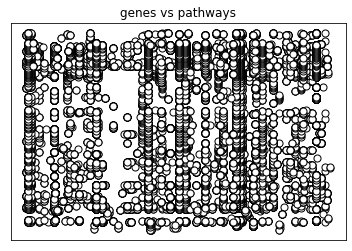

In [74]:
# plot
ax=plt.scatter(
   gene_pathway_matrix.iloc[:,0],gene_pathway_matrix.iloc[:,1],
   c='white', marker='o',
   edgecolor='black', s=50
)
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
plt.title("genes vs pathways")
plt.show()

In [70]:
from sklearn.cluster import KMeans

km = KMeans(
    n_clusters=3, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=0
)
y_km = km.fit_predict(gene_pathway)

ValueError: could not convert string to float: 'POLE'

#### distribution of classes in the dataset

<AxesSubplot:xlabel='Class'>

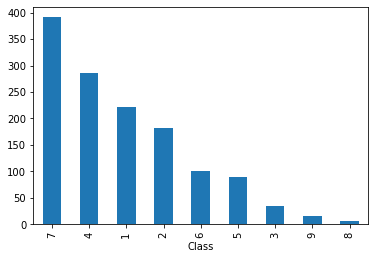

In [19]:
train_df.value_counts('Class').plot(kind='bar')

### <font color='blue'>The mutations are distributed into 9 classes from class 1 to class 9.The distribution of the classes is imbalanced </font>

### <font color='green'> Let us study the mutations of BRCA1, the most highly mutated gene with respect to the classification</font>

In [20]:
train_df[train_df['Gene'] == 'BRCA1']['Variation'].nunique()

101

In [21]:
train_df[train_df['Gene'] == 'BRCA1']['Class'].nunique()

5

In [22]:
train_df[train_df['Gene'] == 'BRCA1'].groupby('Class')['Variation'].count()

Class
1    21
3     3
4    22
5    36
6    19
Name: Variation, dtype: int64

### <font color='green'> 101 mutations (Variations) are classified into 5 classes with most mutations in class 5 and least mutations in class 3</font>

In [23]:
class_5=train_df[(train_df['Gene'] == 'BRCA1') & (train_df['Class']== 5)]
class_5['Text']=class_5['Text'].map(lambda x:x[:80])

In [24]:
class_5.reset_index(inplace=True,drop=True)

In [25]:
class_5

,ID,Gene,Variation,Class,Text
0,2661,BRCA1,S1613C,5,Abstract Germline mutations that inactivate B...
1,2460,BRCA1,R170W,5,Mutations in BRCA1 and BRCA2 account for the m...
2,2558,BRCA1,P1806A,5,ABSTRACT Germline mutations that inactivate th...
3,2618,BRCA1,C1787S,5,Abstract The BRCA1 gene from individuals at ...
4,2468,BRCA1,E362H,5,Mutations in BRCA1 and BRCA2 account for the m...
5,2673,BRCA1,S1473P,5,Abstract Germline inactivating mutations in B...
6,2472,BRCA1,L358R,5,Mutations in BRCA1 and BRCA2 account for the m...
7,2502,BRCA1,A1789S,5,Genetic screening of the breast and ovarian ca...
8,2423,BRCA1,A1830T,5,Genetic screening of the breast and ovarian ca...
9,2663,BRCA1,P1614S,5,Germ line inactivating mutations in BRCA1 conf...


In [26]:
class_5.groupby(['Text','Gene'],sort=False)['Variation'].count().reset_index()

,Text,Gene,Variation
0,Abstract Germline mutations that inactivate B...,BRCA1,2
1,Mutations in BRCA1 and BRCA2 account for the m...,BRCA1,15
2,ABSTRACT Germline mutations that inactivate th...,BRCA1,2
3,Abstract The BRCA1 gene from individuals at ...,BRCA1,6
4,Abstract Germline inactivating mutations in B...,BRCA1,3
5,Genetic screening of the breast and ovarian ca...,BRCA1,4
6,Germ line inactivating mutations in BRCA1 conf...,BRCA1,1
7,A significant proportion of inherited breast c...,BRCA1,1
8,BRCA1 is a tumour suppressor with pleiotropic ...,BRCA1,1
9,ABSTRACT: The BRCA1 tumor suppressor gene is f...,BRCA1,1


### <font style="font-size:18px;font-family:arial;color:green;text-indent:100px;line-height:0.8;word-spacing:10px">What is the relationship of the enlisted mutations (Variation) of a gene and the corresponding 'Text' ? For e.g, for mutations of BCRA1, there are 36 unique mutations assigned to class 5 and the above 10 texts are the basis for it</font>

In [27]:
train_df.isna().sum()

ID           0
Gene         0
Variation    0
Class        0
Text         4
dtype: int64

In [28]:
train_df[train_df['Text'].map(lambda x:not isinstance(x,str))]

,ID,Gene,Variation,Class,Text
1407,1407,FGFR3,K508M,6,NaN
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1639,1639,FLT1,Amplification,6,NaN


In [29]:
train_df.dropna(inplace=True)

In [30]:
from sklearn.model_selection import train_test_split

In [32]:
y_train=train_df['Class']
X_train=train_df.drop('Class',axis=1)
train_df,validation_df,y_train,y_validation=train_test_split(X_train,y_train,test_size=0.3,stratify=y_train)

In [33]:
train_df.shape,y_train.shape

((926, 4), (926,))

In [35]:
set(y_train.tolist())

{1, 2, 3, 4, 5, 6, 7, 8, 9}

In [34]:
validation_df.shape,y_validation.shape

((398, 4), (398,))

In [36]:
set(y_validation.tolist())

{1, 2, 3, 4, 5, 6, 7, 8, 9}

### <font color='green'>analyzing the train text data</font>

[link to destination](#destination)

In [37]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [38]:
revised_punctuation='!"#$%&\'()*+,./:;<=>?@[\\]^_`{|}~'

In [39]:
revised_punctuation

'!"#$%&\'()*+,./:;<=>?@[\\]^_`{|}~'

In [40]:
#!pip install nltk

In [41]:
import nltk
nltk.download('words')
from nltk.corpus import words
words=nltk.corpus.words.words()

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\anubr\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


In [42]:
len(set(words))

235892

In [43]:
nltk_words=set(words)

In [44]:
def cleanse_data(data):        
    if isinstance(data,str):
        no_punctuation = [char for char in data.replace('\n',' ') if char not in revised_punctuation]
        no_punctuation_txt = ''.join(no_punctuation)                   
        return no_punctuation_txt
    else:
        return "NA"

In [45]:
def reduce_words(data):
    data = data.split()
    words = [word for word in data if word not in nltk_words]
    text = " ".join(words)
    return text    

In [46]:
def word_count(text):
    text_lst=text.split()
    vector = [text_lst.count(str(word)) for word in text_lst]
    return vector[:300]

In [47]:
from nltk.probability import FreqDist

we have obtained the frequency distribution of words using freqdist

In [48]:
def freq_dist(data):
    data=data.split(" ")
    freq=FreqDist(data) # gets word frequency
    freq=sorted(freq.items(),key=lambda x:x[1], reverse=True) # sorts words from highest to lowest frequency
    return [item[1] for item in freq][:300] # returns a fixed length of 300 words

In [49]:
# implementing bag of words

In [50]:
from sklearn.feature_extraction.text import CountVectorizer

In [51]:
bow_vectorizer = CountVectorizer(stop_words='english',max_features=1600)

In [52]:
# implementing tf-idf

In [53]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [54]:
tfidf_vectorizer = TfidfVectorizer(
    min_df=1, max_features=1600, strip_accents='unicode',lowercase =True,
    analyzer='word', token_pattern=r'\w+', ngram_range=(1, 3), use_idf=True, 
    smooth_idf=True, sublinear_tf=True, stop_words = 'english')

In [55]:
# https://melaniewalsh.github.io/Intro-Cultural-Analytics/05-Text-Analysis/03-TF-IDF-Scikit-Learn.html
# https://www.datacamp.com/community/tutorials/understanding-logistic-regression-python
# https://machinelearningmastery.com/multinomial-logistic-regression-with-python/
# https://www.kaggle.com/elemento/personalizedmedicine-rct

In [56]:
from sklearn.linear_model import LogisticRegression

In [57]:
from sklearn.metrics import log_loss

In [58]:
# define the multinomial logistic regression model
bow_model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
tfidf_model = LogisticRegression(multi_class='multinomial', solver='lbfgs')

<a id="train_data" style="font-size:22px">model train text sample data</a>

[Beginning of Notebook](#top)

#### text preprocessing

In [59]:
# remove punctuation
train_df['cleaned_text'] = train_df['Text'].progress_map(cleanse_data,na_action='ignore')

progress bar: 100%|██████████| 926/926 [00:09<00:00, 92.83it/s] 


In [60]:
# filtering all common english words
train_df['cleaned_text'] = train_df['cleaned_text'].progress_map(reduce_words,na_action='ignore')

progress bar: 100%|██████████| 926/926 [00:03<00:00, 249.31it/s]


In [61]:
train_df['Text_len'] = train_df['Text'].map(lambda x:len(str(x)))
train_df['cleaned_text_len'] = train_df['cleaned_text'].map(lambda x:len(str(x)))

In [62]:
train_df.head()

,ID,Gene,Variation,Text,cleaned_text,Text_len,cleaned_text_len
2416,2416,PTPRD,Deletion,Tyrosine phosphorylation plays a critical role...,Tyrosine plays regulating signaling cascades o...,65803,27030
1636,1636,MAP2K4,G85R,The systematic characterization of somatic mut...,mutations genomes developing therapeutics1 Her...,53189,24152
389,389,TP53,S121A,Tumor suppressor p53-dependent apoptosis is th...,Tumor p53-dependent apoptosis tumor-suppressiv...,29923,12382
1194,1194,PIK3CA,R93W,"Introduction In 2004, Samuels et al. reported...",Introduction In 2004 Samuels et reported resul...,78779,32007
766,766,ERBB2,N857S,Overexpression of the ERBB2 kinase is observed...,Overexpression ERBB2 observed one-third patien...,21840,10012


### <font color='green'>converting text to numbers</font>

In [63]:
train_df_corpus = train_df['cleaned_text'].tolist()

#### bag of words transformation

In [64]:
bow_vectorizer.fit(train_df_corpus)

CountVectorizer(max_features=1600, stop_words='english')

In [65]:
train_df_counts= bow_vectorizer.transform(train_df_corpus)

In [66]:
print("Vocabulary: ", bow_vectorizer.vocabulary_)

Vocabulary:  {'tyrosine': 1529, 'plays': 1161, 'regulating': 1268, 'signaling': 1372, 'oncogenesis': 1083, 'controlled': 444, 'kinases': 875, 'roles': 1316, 'ptprd': 1224, 'inactivated': 811, 'glioblastoma': 719, 'gbm': 695, 'tumors': 1523, 'deletions': 505, 'cancer': 350, 'specific': 1405, 'silencing': 1376, 'cpg': 460, '37': 109, 'sequencing': 1357, 'mutated': 1017, '13': 36, 'carcinomas': 352, 'cancers': 351, 'mutations': 1020, 'occurs': 1077, '50': 134, 'patients': 1120, 'wild': 1578, 'type': 1526, 'inhibits': 834, 'cells': 375, 'observed': 1072, 'alleles': 238, 'harboring': 741, 'human': 777, 'lacking': 883, 'exhibited': 616, 'increased': 815, 'stat3': 1418, 'results': 1297, 'keywords': 872, 'loss': 918, 'leads': 891, 'genes': 705, 'mechanisms': 956, 'dna': 543, 'identification': 784, 'processes': 1199, 'identified': 785, 'conserved': 432, 'members': 971, 'implicated': 807, 'tumorigenesis': 1521, 'encodes': 583, 'transmembrane': 1508, 'located': 912, 'gliomas': 720, 'malignancies'

In [67]:
train_df_counts.shape

(926, 1600)

In [68]:
train_df_counts

<926x1600 sparse matrix of type '<class 'numpy.int64'>'
	with 392684 stored elements in Compressed Sparse Row format>

In [69]:
X_train_bow = train_df_counts.todense()

In [70]:
X_train_bow.shape

(926, 1600)

In [71]:
X_train_bow

matrix([[ 0,  0,  0, ...,  2,  0,  1],
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  1,  3],
        ...,
        [ 0,  3,  0, ...,  0,  1,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        [29,  0,  0, ...,  0,  0,  0]], dtype=int64)

#### tfidf transformation

In [72]:
tfidf_vectorizer.fit(train_df_corpus)

TfidfVectorizer(max_features=1600, ngram_range=(1, 3), stop_words='english',
                strip_accents='unicode', sublinear_tf=True,
                token_pattern='\\w+')

In [73]:
X_train_tfidf = tfidf_vectorizer.transform(train_df_corpus)
X_train_tfidf = X_train_tfidf.toarray()

In [74]:
X_train_tfidf.shape

(926, 1600)

In [75]:
X_train_tfidf

array([[0.02639888, 0.        , 0.        , ..., 0.03449868, 0.        ,
        0.03118394],
       [0.04686609, 0.03285742, 0.        , ..., 0.        , 0.01757402,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.02530288,
        0.09614146],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.0250747 ,
        0.        ],
       [0.01531941, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.09580715, 0.03812885, 0.1622643 , ..., 0.        , 0.        ,
        0.        ]])

### <font color='green'>creating baseline metrics using hard coded predicted values</font>

In [76]:
from numpy import random

In [77]:
# create a dummy y value for getting the baseline accuracy
y_dummy_1 = random.rand(926,9)

In [78]:
#y_dummy

In [79]:
y_train.head()

2416    4
1636    4
389     2
1194    7
766     2
Name: Class, dtype: int64

In [80]:
y_dummy_1[0,:]

array([0.91925338, 0.1380678 , 0.03601908, 0.01446142, 0.17844071,
       0.68686261, 0.36260128, 0.6113832 , 0.11614302])

In [81]:
# baseline loss metric value, random y values
log_loss(y_train,y_dummy_1)

2.503748209083961

In [82]:
y_dummy_2=np.zeros((926,9),dtype='float')

In [83]:
y_dummy_2[0,:]

array([0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [84]:
# baseline loss metric value, all probabilites for y set to zero
log_loss(y_train,y_dummy_2)

2.197224577336219

In [85]:
# baseline loss metric value, all probabilites for y set to 0.4
y_dummy_3=np.full((926,9),0.4,dtype='float')

In [86]:
y_dummy_3[0,:]

array([0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4])

In [87]:
log_loss(y_train,y_dummy_3)

2.1972245773362187

In [88]:
y_dummy_4=np.zeros((926,9),dtype='float')

In [89]:
y_dummy_4[:,0]=1.0

In [90]:
y_dummy_4[0,:]

array([1., 0., 0., 0., 0., 0., 0., 0., 0.])

In [91]:
# baseline loss metric value,probability at index 1 set to 1.0 for all y
log_loss(y_train,y_dummy_4) 

28.794746627290557

In [92]:
# baseline loss metric value,probability at random indices set to 1.0 for all y
y_dummy_5=np.zeros((926,9),dtype='float')
count=0
for x in X_train_bow:
    new_y_val=np.random.randint(0,9)
    y_dummy_5[count,new_y_val]=1.    
    count=count+1  

In [93]:
y_dummy_5[0,:]

array([0., 0., 0., 0., 0., 0., 1., 0., 0.])

In [94]:
log_loss(y_train,y_dummy_5)

30.473196884062677

In [95]:
# baseline loss metric value,probability at random indices set to 1.0 for all y
def get_dummy(train_df):
    y_dummy_5=np.zeros((926,9),dtype='float') # creating the probability matrix for y values
    count=0
    for x in train_df:                        # iterating through the training dataset
        new_y_val=np.random.randint(0,9)      # creating random values for substituting index values
        y_dummy_5[count,new_y_val]=1.         # setting the random index value as 1.0
        count=count+1  
    return y_dummy_5    

In [96]:
def simulate_dummy(train_df,y_train):    
    for i in range(10):
        y_dummy=get_dummy(train_df)
        print(log_loss(y_train,y_dummy))

In [97]:
simulate_dummy(train_df,y_train)

2.4417071504712315
2.4044082558762954
2.4417071504712315
2.3671093612813596
2.4417071504712315
2.4417071504712315
2.4044082558762954
2.4417071504712315
2.4044082558762954
2.4044082558762954


In [98]:
pd.DataFrame({"substitutions":["random","all zero","all 0.4","index 1","random index"],"log_loss":[2.49,2.19,2.19,28.59,2.4]})

,substitutions,log_loss
0,random,2.49
1,all zero,2.19
2,all 0.4,2.19
3,index 1,28.59
4,random index,2.40


### <font style="font-size:18px;font-family:arial;color:green;text-indent:100px;line-height:0.8;word-spacing:10px">Thus the lowermost limit for log loss score for an inaccurate model returns a value of 2.4 and hence our models should return better scores</font> 

### <font color='blue'>Logistic Regression Model</font>

In [99]:
from sklearn.metrics import accuracy_score

#### <font color='blue'>Logistic Regression with bag of words transformation</font>

In [100]:
bow_model.fit(X_train_bow,y_train)

LogisticRegression(multi_class='multinomial')

In [101]:
sorted(bow_model.coef_.tolist()[0])[:5]

[-0.1740198427292691,
 -0.16348008421219223,
 -0.1483252726236837,
 -0.1410318482175016,
 -0.13964292704069578]

In [102]:
bow_model.classes_

array([1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

In [103]:
bow_model.n_features_in_

1600

In [104]:
bow_model.intercept_

array([ 0.01082679,  0.00691368, -0.00959323, -0.00414498, -0.01551513,
        0.00916417,  0.02552851, -0.01115514, -0.01202465])

In [105]:
set(y_train.tolist())

{1, 2, 3, 4, 5, 6, 7, 8, 9}

In [106]:
y_pred_train_bow = bow_model.predict_proba(X_train_bow)

In [107]:
y_pred_train_bow2=bow_model.predict(X_train_bow)

#### <font color='purple'>scoring the prediction using multiple scoring metrics</font>

In [108]:
log_loss(y_train,y_pred_train_bow)

0.1743412647879297

In [109]:
from sklearn.metrics import classification_report

In [110]:
target_names=['class 1','class 2','class 3','class 4','class 5','class 6','class 7','class 8','class 9']

In [111]:
print(classification_report(y_train, y_pred_train_bow2, target_names=target_names))

              precision    recall  f1-score   support

     class 1       0.91      0.91      0.91       154
     class 2       0.96      0.94      0.95       127
     class 3       0.80      0.64      0.71        25
     class 4       0.94      0.94      0.94       200
     class 5       0.73      0.82      0.77        62
     class 6       0.90      0.87      0.88        69
     class 7       0.95      0.96      0.96       274
     class 8       1.00      1.00      1.00         4
     class 9       1.00      0.91      0.95        11

    accuracy                           0.92       926
   macro avg       0.91      0.89      0.90       926
weighted avg       0.92      0.92      0.92       926



In [112]:
from sklearn.metrics import plot_confusion_matrix

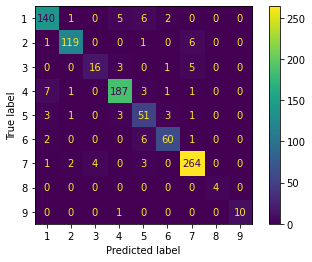

In [113]:
plot_confusion_matrix(bow_model, X_train_bow, y_train)

#### <font color='blue'>Logistic Regression with tfidf transformation</font>

In [114]:
tfidf_model.fit(X_train_tfidf,y_train)

LogisticRegression(multi_class='multinomial')

In [115]:
sorted(tfidf_model.coef_.tolist()[0])[:5]

[-0.7345981419926653,
 -0.6743989375026752,
 -0.6067290918834538,
 -0.6053578869600281,
 -0.5559113311505284]

In [116]:
tfidf_model.classes_

array([1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

In [117]:
tfidf_model.n_features_in_

1600

In [118]:
tfidf_model.intercept_

array([ 1.03261604,  1.00998938, -0.41740851,  1.15194037,  0.25972305,
        0.33764811,  0.83916211, -2.48908216, -1.72458839])

In [119]:
y_pred_train_tfidf = tfidf_model.predict_proba(X_train_tfidf)

In [120]:
y_pred_train_tfidf2 = tfidf_model.predict(X_train_tfidf)

#### <font color='purple'>scoring the prediction using multiple scoring metrics</font>

In [121]:
log_loss(y_train,y_pred_train_tfidf)

0.995358810332309

In [122]:
print(classification_report(y_train, y_pred_train_tfidf2, target_names=target_names))

              precision    recall  f1-score   support

     class 1       0.75      0.75      0.75       154
     class 2       0.84      0.46      0.59       127
     class 3       0.00      0.00      0.00        25
     class 4       0.74      0.87      0.80       200
     class 5       0.69      0.44      0.53        62
     class 6       0.88      0.51      0.64        69
     class 7       0.68      0.97      0.80       274
     class 8       0.00      0.00      0.00         4
     class 9       0.00      0.00      0.00        11

    accuracy                           0.73       926
   macro avg       0.51      0.44      0.46       926
weighted avg       0.71      0.73      0.70       926



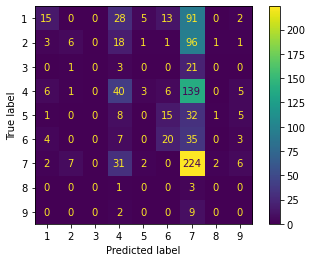

In [123]:
plot_confusion_matrix(tfidf_model, X_train_bow, y_train)

### <font color='blue'> Multinomial Naive Bayes Model<font>

In [124]:
from sklearn.naive_bayes import MultinomialNB

#### <font color='purple'>bag of words transformation</font>

In [125]:
NB_clf=MultinomialNB()

In [126]:
NB_clf.fit(X_train_bow,y_train)

MultinomialNB()

In [127]:
NB_clf.class_count_

array([154., 127.,  25., 200.,  62.,  69., 274.,   4.,  11.])

In [128]:
y_pred_train_NB=NB_clf.predict_proba(X_train_bow)

In [129]:
y_pred_train_NB2=NB_clf.predict(X_train_bow)

#### <font color='purple'>scoring the prediction using multiple scoring metrics</font>

In [130]:
log_loss(y_train,y_pred_train_NB)

12.705268924882242

In [131]:
print(classification_report(y_train, y_pred_train_NB2, target_names=target_names))

              precision    recall  f1-score   support

     class 1       0.63      0.71      0.67       154
     class 2       0.52      0.75      0.62       127
     class 3       0.31      0.92      0.46        25
     class 4       0.79      0.44      0.56       200
     class 5       0.43      0.56      0.49        62
     class 6       0.73      0.58      0.65        69
     class 7       0.80      0.62      0.70       274
     class 8       0.17      1.00      0.29         4
     class 9       0.80      0.73      0.76        11

    accuracy                           0.62       926
   macro avg       0.57      0.70      0.58       926
weighted avg       0.68      0.62      0.63       926



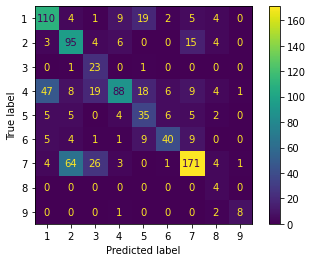

In [132]:
plot_confusion_matrix(NB_clf, X_train_bow, y_train)

### Validation dataset

In [133]:
validation_df.shape,y_validation.shape

((398, 4), (398,))

In [134]:
validation_df.head()

,ID,Gene,Variation,Text
2269,2269,PTEN,H93D,The PTEN (phosphatase and tensin homolog) phos...
1485,1485,FGFR2,A389T,Oncogenic activation of tyrosine kinases is a ...
3063,3063,MED12,L1224F,The human thyroid hormone receptor-associated ...
367,367,EPAS1,P531A,Abstract Deletion of the von Hippel-Lindau tu...
3149,3149,KRAS,K117N,Mutations in RAS proteins occur widely in huma...


#### text processing of validation data

In [135]:
# remove punctuation
validation_df['cleaned_text'] = validation_df['Text'].progress_map(cleanse_data,na_action='ignore')

progress bar: 100%|██████████| 398/398 [00:07<00:00, 52.90it/s]


In [136]:
# filtering all common english words
validation_df['cleaned_text'] = validation_df['cleaned_text'].progress_map(reduce_words,na_action='ignore')

progress bar: 100%|██████████| 398/398 [00:03<00:00, 118.59it/s]


In [137]:
validation_df['Text_len'] = validation_df['Text'].map(lambda x:len(str(x)))
validation_df['cleaned_text_len'] = validation_df['cleaned_text'].map(lambda x:len(str(x)))

In [138]:
validation_df.head()

,ID,Gene,Variation,Text,cleaned_text,Text_len,cleaned_text_len
2269,2269,PTEN,H93D,The PTEN (phosphatase and tensin homolog) phos...,PTEN tensin homolog mammals terms exerted deph...,42789,18457
1485,1485,FGFR2,A389T,Oncogenic activation of tyrosine kinases is a ...,Oncogenic kinases druggable enzymes Here mutat...,23350,10665
3063,3063,MED12,L1224F,The human thyroid hormone receptor-associated ...,receptor-associated TRAP-Mediator identified m...,151754,66501
367,367,EPAS1,P531A,Abstract Deletion of the von Hippel-Lindau tu...,Abstract Deletion von Hippel-Lindau Vhl podocy...,72388,30754
3149,3149,KRAS,K117N,Mutations in RAS proteins occur widely in huma...,Mutations RAS proteins Prompted KRAS biomarker...,62587,27169


In [139]:
validation_df_corpus = validation_df['cleaned_text'].tolist()

##### Bag of words transformation

In [140]:
validation_df_counts= bow_vectorizer.transform(validation_df_corpus)

In [141]:
validation_df_counts.shape

(398, 1600)

In [142]:
X_validation_bow = validation_df_counts.todense()

In [143]:
X_validation_bow.shape

(398, 1600)

In [144]:
X_validation_bow[0]

matrix([[0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [145]:
y_pred_validation_bow = bow_model.predict_proba(X_validation_bow)

In [146]:
y_pred_validation_bow2 = bow_model.predict(X_validation_bow)

#### <font color='purple'>scoring the prediction using multiple scoring metrics</font>

In [147]:
set(y_validation.tolist())

{1, 2, 3, 4, 5, 6, 7, 8, 9}

In [148]:
log_loss(y_validation,y_pred_validation_bow)

6.224180745627177

In [149]:
print(classification_report(y_validation, y_pred_validation_bow2, target_names=target_names))

              precision    recall  f1-score   support

     class 1       0.47      0.42      0.44        66
     class 2       0.44      0.51      0.47        55
     class 3       0.25      0.10      0.14        10
     class 4       0.60      0.60      0.60        86
     class 5       0.30      0.26      0.28        27
     class 6       0.72      0.70      0.71        30
     class 7       0.62      0.68      0.64       117
     class 8       0.00      0.00      0.00         2
     class 9       0.80      0.80      0.80         5

    accuracy                           0.55       398
   macro avg       0.47      0.45      0.46       398
weighted avg       0.54      0.55      0.55       398



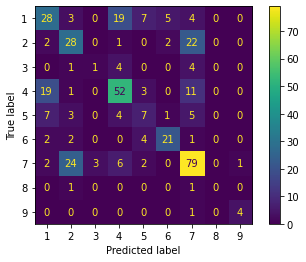

In [150]:
plot_confusion_matrix(bow_model, X_validation_bow, y_validation)

##### TFIDF transformation

In [151]:
X_validate_tfidf = tfidf_vectorizer.transform(validation_df_corpus)

In [152]:
X_validate_tfidf = X_validate_tfidf.toarray()

In [153]:
y_pred_validate_tfidf = tfidf_model.predict_proba(X_validate_tfidf)

In [154]:
y_pred_validate_tfidf2 = tfidf_model.predict(X_validate_tfidf)

#### <font color='purple'>scoring the prediction using multiple scoring metrics</font>

In [155]:
log_loss(y_validation,y_pred_validate_tfidf)

1.2593919472047406

In [156]:
print(classification_report(y_validation, y_pred_validate_tfidf2, target_names=target_names))

              precision    recall  f1-score   support

     class 1       0.45      0.45      0.45        66
     class 2       0.72      0.33      0.45        55
     class 3       0.00      0.00      0.00        10
     class 4       0.54      0.56      0.55        86
     class 5       0.36      0.15      0.21        27
     class 6       1.00      0.47      0.64        30
     class 7       0.56      0.91      0.69       117
     class 8       0.00      0.00      0.00         2
     class 9       0.00      0.00      0.00         5

    accuracy                           0.56       398
   macro avg       0.40      0.32      0.33       398
weighted avg       0.55      0.56      0.52       398



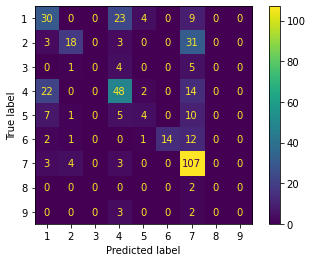

In [157]:
plot_confusion_matrix(tfidf_model, X_validate_tfidf, y_validation)

#### handling the test text sample data

In [158]:
#test_text_df.sort_values(['ID']).head()

In [159]:
#test_text_df.shape

In [160]:
#test_text_df['cleaned_text'] = test_text_df['Text'].map(cleanse_data,na_action='ignore')

In [161]:
#test_text_df['cleaned_text'] = test_text_df['cleaned_text'].map(reduce_words)

In [162]:
#test_text_df['cleaned_text_vector'] = test_text_df['cleaned_text'].map(word_count)

In [163]:
#test_text_df['sorted_cleaned_text_vector'] = test_text_df['cleaned_text'].progress_map(freq_dist)

In [164]:
#test_text_df = test_text_df.drop(['Text'],axis=1)

In [165]:
#test_text_df.head()

In [166]:
# get the text samples as list
#test_corpus = test_text_df['cleaned_text'].tolist()

In [167]:
# transform the test case to get bag of words
#test_bag_of_words_train = bow_vectorizer.fit_transform(test_corpus)

In [168]:
# convert the dictionary to an array
#test_bag_of_words_array = test_bag_of_words_train.toarray()

In [169]:
#test_bag_of_words_array.shape

In [170]:
# predict test using bag of word model
#y_pred_test_bow = bow_model.predict_proba(test_bag_of_words_array)

In [171]:
#y_pred_test_bow[0]

In [172]:
#y_pred_test_df = pd.DataFrame(y_pred_test_bow)

In [173]:
#test_text_df['ID'].shape

In [174]:
#y_pred_test_df['ID']= test_text_df['ID'].reset_index(drop=True)

In [175]:
#y_pred_test_df.head()

In [176]:
# predict test using tfidf model
#y_pred_test_tfidf = tfidf_model.predict_proba(test_bag_of_words_array)

In [177]:
stage2_test_text_df = pd.read_csv('stage2_test_text.csv', sep="\|\|", encoding="utf-8",engine="python", skiprows=1, names=["ID", "Text"])


In [178]:
stage2_test_text_df.shape

(986, 2)

In [179]:
stage2_test_text_df['cleaned_text'] = stage2_test_text_df['Text'].progress_map(cleanse_data,na_action='ignore')

progress bar: 100%|██████████| 986/986 [00:09<00:00, 99.20it/s] 


In [180]:
stage2_test_text_df['cleaned_text'] = stage2_test_text_df['cleaned_text'].progress_map(reduce_words)

progress bar: 100%|██████████| 986/986 [00:04<00:00, 237.01it/s]


In [181]:
stage2_test_text_df.shape

(986, 3)

In [182]:
stage2_cleaned_view =pd.DataFrame({"Text":stage2_test_text_df['Text'].progress_map(lambda x:len(x)),"cleaned_text":stage2_test_text_df['cleaned_text'].map(lambda x:len(x))})
stage2_cleaned_view.head()

progress bar: 100%|██████████| 986/986 [00:00<00:00, 325022.30it/s]


,Text,cleaned_text
0,33403,14418
1,66400,29135
2,58544,26808
3,42023,17996
4,22499,8311


In [183]:
stage2_test_corpus = stage2_test_text_df['cleaned_text'].tolist()

In [184]:
#X_stage2_test = bow_vectorizer.fit_transform(stage2_test_corpus).toarray()

In [185]:
X_stage2_test = tfidf_vectorizer.fit_transform(stage2_test_corpus).toarray()

In [186]:
X_stage2_test.shape

(986, 1600)

In [187]:
y_pred_stage2 = tfidf_model.predict_proba(X_stage2_test)

In [188]:
y_pred_stage2.shape

(986, 9)

In [189]:
y_pred_stage2_df = pd.DataFrame(y_pred_stage2)

In [190]:
y_pred_stage2_df['ID']=stage2_test_text_df['ID']

In [191]:
y_pred_stage2_df.columns

Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 'ID'], dtype='object')

In [192]:
y_pred_stage2_df.columns = ['class1','class2','class3','class4','class5','class6','class7','class8','class9','ID']

In [193]:
y_pred_stage2_df=y_pred_stage2_df[['ID','class1','class2','class3','class4','class5','class6','class7','class8','class9']]

In [194]:
y_pred_stage2_df.head()

,ID,class1,class2,class3,class4,class5,class6,class7,class8,class9
0,1,0.246086,0.124970,0.037631,0.240181,0.058882,0.089237,0.181960,0.006104,0.014948
1,2,0.163249,0.157760,0.029698,0.166447,0.061905,0.056034,0.343224,0.005785,0.015899
2,3,0.164260,0.169408,0.025412,0.238202,0.053039,0.059834,0.266599,0.006214,0.017031
3,4,0.179123,0.162089,0.032706,0.169243,0.055664,0.061590,0.319256,0.005516,0.014814
4,5,0.146846,0.248545,0.032790,0.223710,0.071800,0.052905,0.205449,0.005322,0.012633


In [195]:
y_pred_stage2_df.to_csv("y_pred_stage2.csv",index=False)

In [196]:
df=pd.DataFrame(columns=["Gene","Class","Variation","cleaned_text","cleaned_freq"])
for i in range(19):    
    df_new=class_9[class_9['cleaned_text'] == class_9['cleaned_text'].unique()[i]]
    df=pd.concat([df,df_new])

NameError: name 'class_9' is not defined

we have sorted the frequency dictionary based on values using the key parameter of sorted and higher values first using reverse

In [ ]:
sorted(test_dic.items(),key=lambda x:x[1], reverse=True)

In [ ]:
for i in range(10):
    print(scan_data1[i])

In [ ]:
cd /content

In [ ]:
pa_tree=ET.parse('pa2021.xml')

In [ ]:
root=pa_tree.getroot()

In [ ]:
# for child in root:
#   print(child.tag)

In [ ]:
for element_1 in root:
  #print("---------level_1-----------")
  #print(element_1.tag)
  
  for element_2 in element_1:
    #print("---------level_2-----------")
    #print("    "+element_2.tag," ",element_2.text)
    
    for element_3 in element_2:
      #print("---------level_3-----------")
      #print("        "+element_3.tag," ",element_3.text)
      
      for element_4 in element_3:
        #print("---------level_4-----------")
        if element_4.tag=="String":
          print("                   "+element_4.tag," ",element_4.text)
          
  #break
    

In [ ]:
len(root)

In [ ]:
desc_tree=ET.parse('desc2021.xml')

In [ ]:
desc_root=desc_tree.getroot()

In [ ]:
len(desc_root)

In [ ]:
term_description=[]
for element_1 in desc_root:
  #print("-------level_1----------")
  #print(element_1.tag," ",element_1.text)
  for element_2 in element_1:
    #print("    ----------level_2----------")
    #print("    "+element_2.tag," ",element_2.text)
    for element_3 in element_2:
      if element_3.tag=='String':
        #print("        ---------level_3--------")
        #print("        "+element_3.tag," ",element_3.text)
        term_description.append(element_3.text)

  #break

In [ ]:
len(term_description)

In [ ]:
term_description[:10]

In [ ]:
import csv 
with open('term_description.csv', 'w') as f: 
    write = csv.writer(f) 
    write.writerow(term_description) 
    

There are 2 ways to remove punctuation. one is to use the string library punctuation module on the text before tokenization, the other is to use the nltk.punct library

In [ ]:
len(scan_data1[1])

In [ ]:
#nltk.word_tokenize(scan_data1[1])

In [ ]:
# import string punctuation
import string
string.punctuation

In [ ]:
len(cleanup_text(scan_data1[1]))

In [ ]:
scan_data